<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


%matplotlib inline

In [2]:
batch_size = 16
mean, std = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10("/content/data", train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10("/content/data", train=False, download=True, transform=test_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)


100%|██████████| 170498071/170498071 [00:01<00:00, 103991197.75it/s]


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


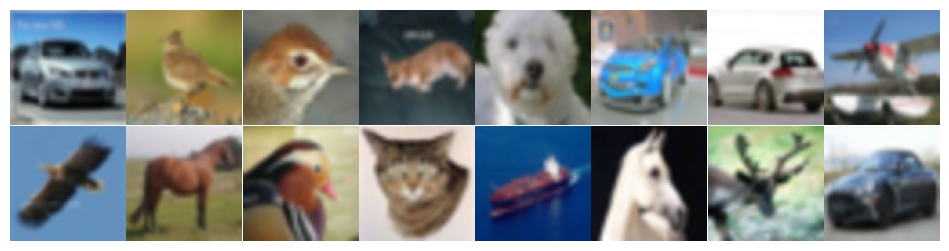

In [3]:
def unnormalize(imgs, mean, std):
  mean = [-x for x in mean]
  std = [1/x for x in std]
  invTrans = transforms.Compose([
      transforms.Normalize(mean = [mean*std for mean, std in zip(mean, std)], std = std),
  ])
  for idx in range(imgs.shape[0]):
    imgs[idx] = invTrans(imgs[idx])
  return imgs


def imshow(img_batch, rows, fig_size):
  img_batch = unnormalize(img_batch, mean, std)
  n_imgs = img_batch.size(0)
  columns = math.ceil(n_imgs/rows)
  plt.figure(figsize=(fig_size * columns / rows, fig_size))
  for i in range(n_imgs):
      img = np.transpose(img_batch[i].numpy(), (1, 2, 0))
      plt.subplot(rows, columns, i+1)
      plt.axis("off")
      plt.imshow(np.clip(img, 0, 1))
  plt.subplots_adjust(hspace=0, wspace=0)
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(images, rows=2, fig_size=3)

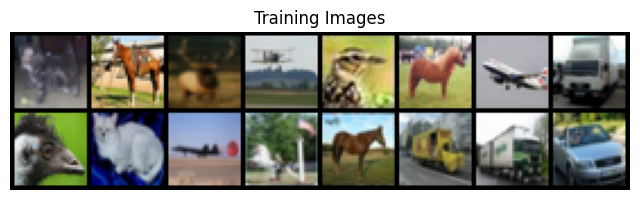

In [57]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(images[:], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:


class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layer1 = self._make_layers(100, 512, 1, 0)
    self.layer2 = self._make_layers(512, 256, 2)
    self.layer3 = self._make_layers(256, 128, 2)
    self.layer4 = self._make_layers(128, 64, 2)
    self.layer5 = nn.Sequential(
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
    )


  def _make_layers(self, in_chans, out_chans, stride=1, padding=1):
    block = nn.Sequential(
        nn.ConvTranspose2d(in_chans, out_chans, kernel_size=4, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_chans),
        nn.LeakyReLU(0.2),
    )
    return block

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    return x


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(0.3, inplace=True)
    )
    self.layer2 = self._make_layers(64, 128, 2)
    self.layer3 = self._make_layers(128, 256, 2)
    self.layer4 = self._make_layers(256, 512, 2)
    self.layer5 = nn.Sequential(
        nn.Conv2d(512, 1, 4, 1, bias=False),
        nn.Sigmoid()
    )



  def _make_layers(self, in_chans, out_chans, stride=1, padding=1):
    block = nn.Sequential(
        nn.Conv2d(in_chans, out_chans, kernel_size=4, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_chans),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(0.3, inplace=True),
    )
    return block

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = x.view(x.size(0))
    return x


In [100]:
model = Discriminator()
x = torch.rand((4, 3, 64, 64))
out = model(x)
out.shape

torch.Size([4, 1])

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_epochs = 10

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=3e-4)
optimizerG = optim.Adam(netG.parameters(), lr=3e-4)

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/3125]	Loss_D: 1.4955	Loss_G: 1.3215	D(x): 0.4769	D(G(z)): 0.5092 / 0.2812
[0/10][100/3125]	Loss_D: 0.0779	Loss_G: 8.1274	D(x): 0.9668	D(G(z)): 0.0382 / 0.0165
[0/10][200/3125]	Loss_D: 0.4776	Loss_G: 6.6517	D(x): 0.9655	D(G(z)): 0.2345 / 0.0142
[0/10][300/3125]	Loss_D: 0.0734	Loss_G: 8.2431	D(x): 0.9703	D(G(z)): 0.0344 / 0.0026
[0/10][400/3125]	Loss_D: 0.0559	Loss_G: 7.2071	D(x): 0.9639	D(G(z)): 0.0177 / 0.0026
[0/10][500/3125]	Loss_D: 0.8879	Loss_G: 7.4684	D(x): 0.7306	D(G(z)): 0.0067 / 0.0057
[0/10][600/3125]	Loss_D: 0.0549	Loss_G: 7.8435	D(x): 0.9965	D(G(z)): 0.0452 / 0.0013
[0/10][700/3125]	Loss_D: 0.3874	Loss_G: 6.1900	D(x): 0.8529	D(G(z)): 0.0875 / 0.0638
[0/10][800/3125]	Loss_D: 0.0087	Loss_G: 6.6761	D(x): 0.9990	D(G(z)): 0.0077 / 0.0035
[0/10][900/3125]	Loss_D: 0.5296	Loss_G: 4.3455	D(x): 0.7396	D(G(z)): 0.0429 / 0.0587
[0/10][1000/3125]	Loss_D: 0.3237	Loss_G: 5.1741	D(x): 0.9535	D(G(z)): 0.1444 / 0.0584
[0/10][1100/3125]	Loss_D: 0.1698	Loss_G:

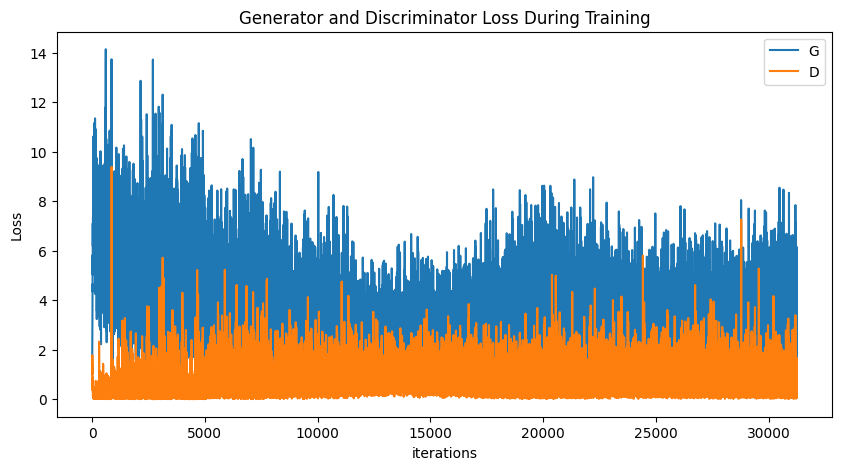

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

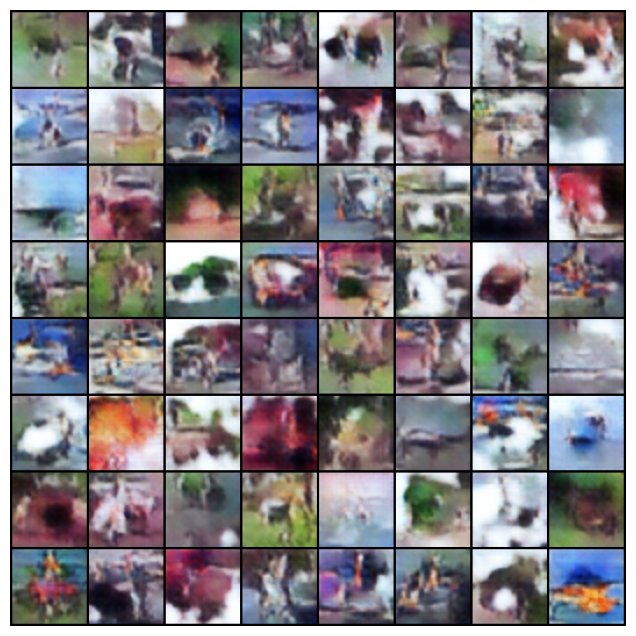

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]


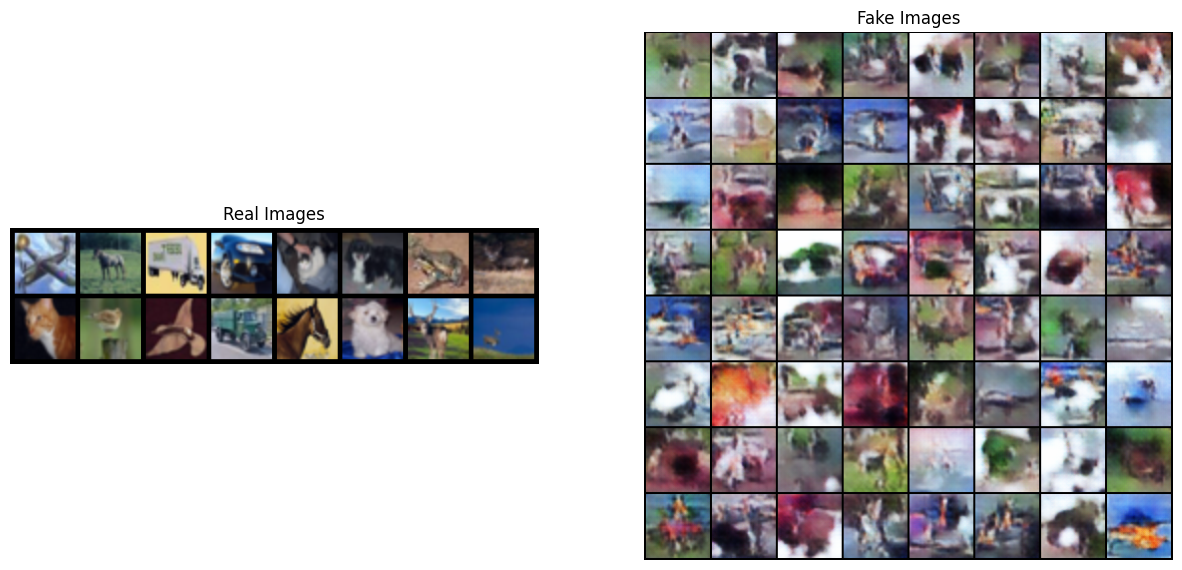

In [10]:
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()